# Major Project: Living Thing Classification

Nottachat Kaewgard

Student ID: 47369833

Kaggle: melnottachat

# Introduction

The task is to work with a dataset of images of living things and predict the category label of the living thing.  Category labels will be predicted at two different levels of granularity in the Linnaean taxonomy of living things, one fore coarse-grained and one for fine-grained.



# Preparation

## Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Machine\ Learning/Major\ Project/living-thing-classification-coarse.zip 

In [ ]:
!ls -alh public

total 32M
drwxr-xr-x 5 root root 4.0K Jun  4 00:36 .
drwxr-xr-x 1 root root 4.0K Jun  4 00:37 ..
-rw-r--r-- 1 root root 1.3K Mar 11 07:25 info.json
drwxr-xr-x 2 root root 7.0M Jun  4 00:36 test
-rw-r--r-- 1 root root 2.5M Mar 11 07:25 test.csv
drwxr-xr-x 2 root root 7.5M Jun  4 00:36 train
-rw-r--r-- 1 root root 4.8M Mar 11 07:55 train.csv
drwxr-xr-x 2 root root 7.1M Jun  4 00:37 val
-rw-r--r-- 1 root root 2.4M Mar 11 08:35 val.csv


In [ ]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import lightgbm

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

import warnings
warnings.filterwarnings('ignore')

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.12.0
Keras Version: 2.12.0
GPU is available


In [ ]:
batch_size = 64
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8
random_state = 47369833
root = Path('/content/public')

In [ ]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y

## Import Data

In [ ]:
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [ ]:
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


### Create datasets for Conventional Machine Learning

The dataset is quite extensive, consisting of 100,000 training images, 50,000 validation images and 50,000 testing images. A portion (10%) of these datasets will be utilized to train and test the model.

In [ ]:
X,Y = create_dataset_sklearn('train', fine_grained=False, percent=0.1)
X_val, Y_val = create_dataset_sklearn('val', fine_grained=False, percent=0.1)
X_test, Y_test = create_dataset_sklearn('test', fine_grained=False, percent=1.0)

In [ ]:
print("Training Images: ", X.shape)
print("Testing Images: ", X_test.shape)
print("Validation Images: ", X_val.shape)

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y[i]])
  else:
    plt.title(coarse_names[Y[i]])
  plt.axis("off")
plt.show();

### Create datasets for Deep Learning

In [ ]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=1000)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=1000)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=1000)

In [ ]:
percent = 0.1
partial_train_ds = train_ds.take(int(len(train_ds) * percent))
partial_val_ds = val_ds.take(int(len(val_ds) * percent))

In [ ]:
print("Training Images: ", len(partial_train_ds) * 1000)
print("Testing Images: ", len(test_ds) * 1000)
print("Validation Images: ", len(partial_val_ds) * 1000)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in partial_train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

# Data Exploration

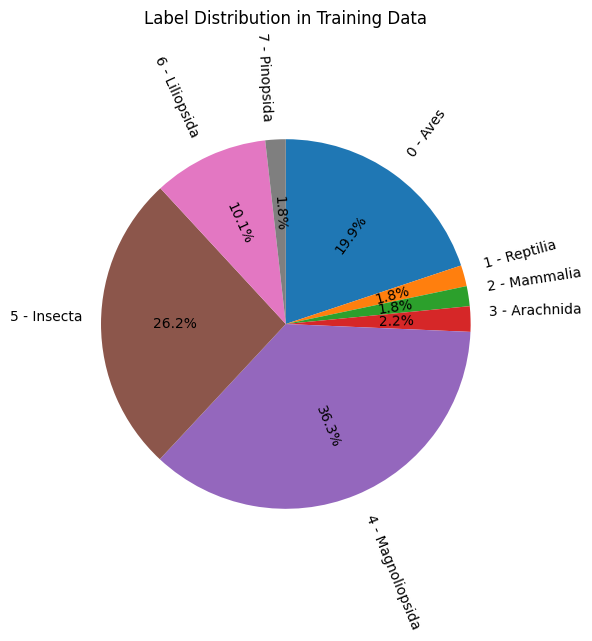

In [ ]:
labels, counts = np.unique(Y, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(8), coarse_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Training Data", pad=50)
plt.show()

In [ ]:
fine_X,fine_Y = create_dataset_sklearn('train', fine_grained=True, percent=0.1)
fine_X_val,fine_Y_val = create_dataset_sklearn('val', fine_grained=True, percent=0.1)

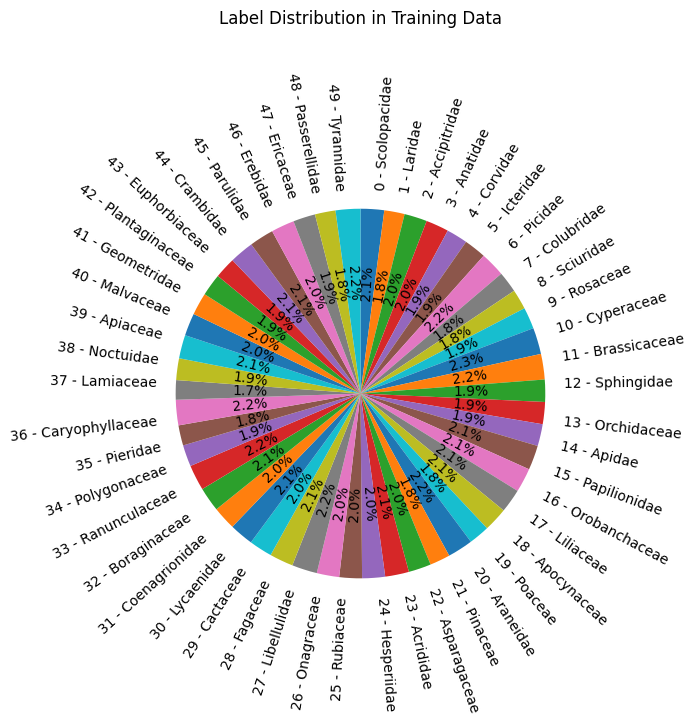

In [ ]:
labels, counts = np.unique(fine_Y, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(len(fine_names)), fine_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Training Data", pad=100)
plt.show()

# Preprocessing

## Resampling

To address the issue of imbalance in the dataset, we will use the SMOTETomek oversampling technique. This method combines over- and under-sampling by adding synthetic samples to the minority class and removing samples from the majority class. This approach aims to balance the dataset and improve the performance of our model.

In [ ]:
from imblearn.combine import SMOTETomek

resample = SMOTETomek(random_state = random_state)
X_res, Y_res = resample.fit_resample(X, Y)

In [ ]:
np.unique(Y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([1987,  184,  175,  222, 3626, 2619, 1009,  178]))

In [ ]:
np.unique(Y_res, return_counts = True)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([3625, 3626, 3626, 3626, 3625, 3624, 3626, 3626]))

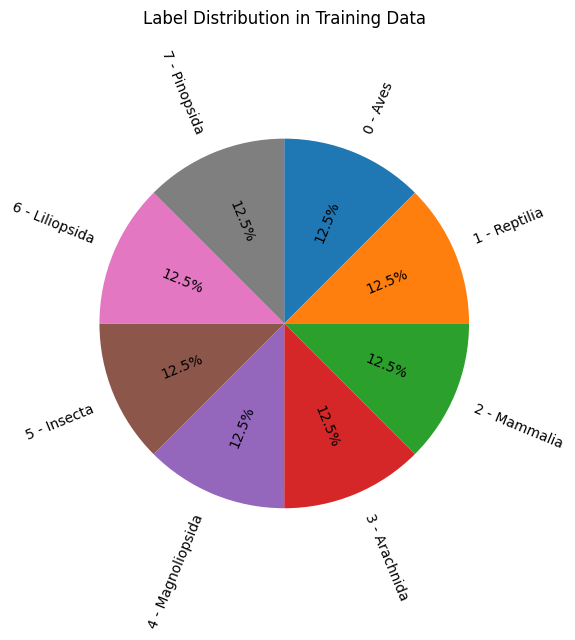

In [ ]:
labels, counts = np.unique(Y_res, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(8), coarse_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Training Data", pad=50)
plt.show()

## PCA

Principal Component Analysis, commonly known as PCA, is a technique for reducing the number of dimensions in a dataset. By doing so, it can help to speed up the training process for machine learning algorithms. Additionally, PCA can enhance the performance of these algorithms by removing noise from the data.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
X_reduced = pca.fit_transform(X)
X_val_reduced = pca.transform(X_val)

In [ ]:
print(X.shape)
print(X_reduced.shape)

(10000, 2304)
(10000, 1304)


In [ ]:
X_recovered = pca.inverse_transform(X_reduced)

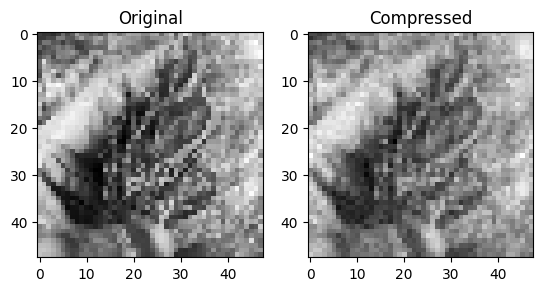

In [ ]:
plt.subplot(1, 2, 1)
plt.title(["Original", "Compressed"][0])
plt.imshow(X[1].reshape(48,48), cmap='gray')
plt.subplot(1, 2, 2)
plt.title(["Original", "Compressed"][1])
plt.imshow(X_recovered[1].reshape(48,48), cmap='gray')

# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy 51%) was an LightGBM. The algorithm was developed by Microsoft and is based on Decision Trees.

In [ ]:
light_clf = lightgbm.LGBMClassifier(
    random_state = random_state,
    num_leaves = 100, #default 31 
    num_iterations = 500, # default 100
    boosting = 'dart', # default SGD
    num_class = len(coarse_names),
    objective = 'multiclass'
)

light_clf.fit(X, Y)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


LGBMClassifier(boosting='dart', num_class=8, num_iterations=500, num_leaves=100,
               objective='multiclass', random_state=5555)

In [ ]:
lgbm_train_pred = light_clf.predict(X)
lgbm_train_accuracy = accuracy_score(Y, lgbm_train_pred)
print("Accuracy on Training Data", "{:.2%}".format(lgbm_train_accuracy))

Accuracy on Training Data 100.00%


In [ ]:
lgbm_val_pred = light_clf.predict(X_val)
lgbm_val_accuracy = accuracy_score(Y_val, lgbm_val_pred)
print("Accuracy on Validation Data", "{:.2%}".format(lgbm_val_accuracy))

Accuracy on Validation Data 51.82%


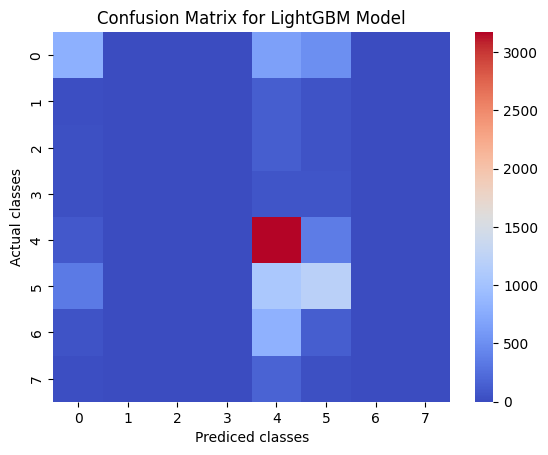

In [ ]:
lgbm_cm_2 = confusion_matrix(Y_val, lgbm_val_pred_2)
sns.heatmap(lgbm_cm_2, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for LightGBM Model")
plt.show()

In [ ]:
print(classification_report(Y_val, lgbm_val_pred_2))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48      1950
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       222
           3       0.50      0.01      0.01       175
           4       0.51      0.88      0.65      3613
           5       0.50      0.46      0.48      2614
           6       0.33      0.00      0.00      1001
           7       1.00      0.00      0.01       213

    accuracy                           0.52     10000
   macro avg       0.43      0.22      0.20     10000
weighted avg       0.49      0.52      0.45     10000



## Performance Comparison

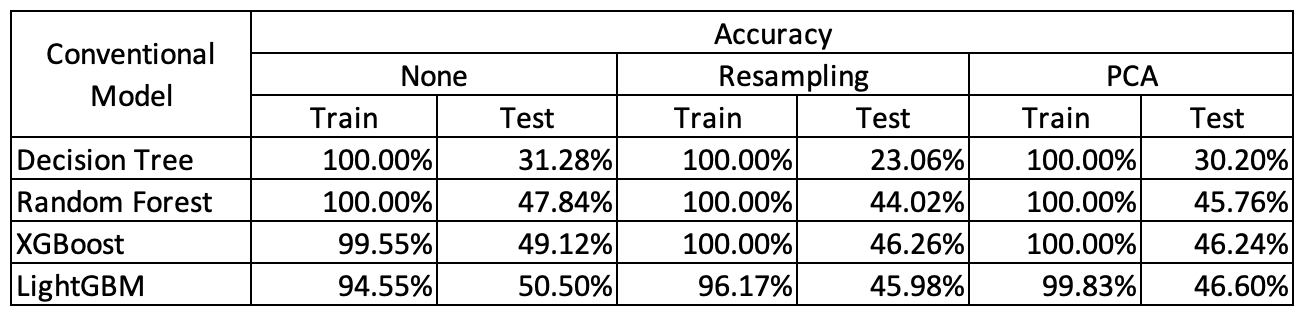

# Notes on the Conventional ML Model

- Using the default configuration, LightGBM outperforms other conventional machine learning models.

- According to the classification report, all models failed to accurately predict four labels: 1 - Reptilia, 2 - Mammalia, 3 - Arachnida, and 7 - Pinopsida. The resampling technique doesn't help much in this case as the recall ratios for these labels were very small, indicating that the models were unable to correctly identify instances of these classes. 

- When we trained a model using data that had been compressed with PCA, its performance was worse than that of a model trained on uncompressed data. 

- It is worth mentioning that all models exhibit signs of overfitting.

- LightGBM is more efficient in terms of execution time and has the highest accuracy among the models tested. As a result, it has been chosen as the model for this task.

- By fine-tuning the LightGBM model and changing the boosting parameter from SGD to Dart, as well as increasing the number of num_leaves and num_iterations, we were able to achieve a 1-2% increase in accuracy. However, this resulted in an increase in the training time of the model.

# Deep Learning Model

## EfficientNetV2

EfficientNetV2 is a top-performing model for image classification, with multiple variations available depending on the size of the input image. The model is trained with 10,000,000 labeled images and more than 10,000 object categories (ImageNet, n.d.). The model has been developed and fine-tuned for different image sizes, including S (384 x 384), M (480 x 480), L (480 x 480), and XL (512 x 512). For this task, the EfficientNetV2 (XL) model fine-tuned on the ImageNet1K dataset was chosen.

In [ ]:
train_ds = create_dataset_tf('train', fine_grained=False, batch_size=1000, image_size = 512)
val_ds = create_dataset_tf('val', fine_grained=False, batch_size=1000, image_size = 512)

In [ ]:
percent = 0.1
partial_train_ds = train_ds.take(int(len(train_ds) * percent))
partial_val_ds = val_ds.take(int(len(val_ds) * percent))

In [ ]:
efficientnet_v2_xl = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2"

In [ ]:
tf.random.set_seed(42)
tf.keras.backend.clear_session() # extra code – resets layer name counter

base_model = hub.KerasLayer(efficientnet_v2_xl, trainable = False, name ="EfficientNetV2_xl")


ENV2_xl_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(512, 512, 3)),
    base_model,
    tf.keras.layers.Dense(8, activation="softmax", name="pred")
])

In [ ]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=base_learning_rate)
ENV2_xl_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
ENV2_xl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2_xl (KerasLay  (None, 1280)             207615832 
 er)                                                             
                                                                 
 pred (Dense)                (None, 8)                 10248     
                                                                 
Total params: 207,626,080
Trainable params: 10,248
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
ENV2_xl_checkpoint = tf.keras.callbacks.ModelCheckpoint("ENV2_xl_checkpoints", save_weights_only = True)
ENV2_xl_model_history = ENV2_xl_model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[ENV2_xl_checkpoint])

Epoch 1/5
1563/1563 [==============================] - 1752s 1s/step - loss: 0.3097 - accuracy: 0.9464 - val_loss: 0.3952 - val_accuracy: 0.9348
Epoch 2/5
1563/1563 [==============================] - 1738s 1s/step - loss: 0.2650 - accuracy: 0.9479 - val_loss: 0.3752 - val_accuracy: 0.9348
Epoch 3/5
1563/1563 [==============================] - 1738s 1s/step - loss: 0.2472 - accuracy: 0.9488 - val_loss: 0.3628 - val_accuracy: 0.9345
Epoch 4/5
1563/1563 [==============================] - 1737s 1s/step - loss: 0.2352 - accuracy: 0.9492 - val_loss: 0.3538 - val_accuracy: 0.9344
Epoch 5/5
1563/1563 [==============================] - 1737s 1s/step - loss: 0.2260 - accuracy: 0.9500 - val_loss: 0.3467 - val_accuracy: 0.9342


In [ ]:
ENV2_xl_pred_class = ENV2_xl_pred.argmax(axis=1)
ENV2_xl_pred_class

array([6, 2, 4, ..., 0, 7, 7])

## Performance Comparison

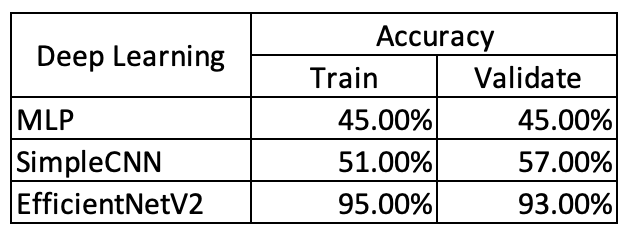

### **MLP Model Summary**

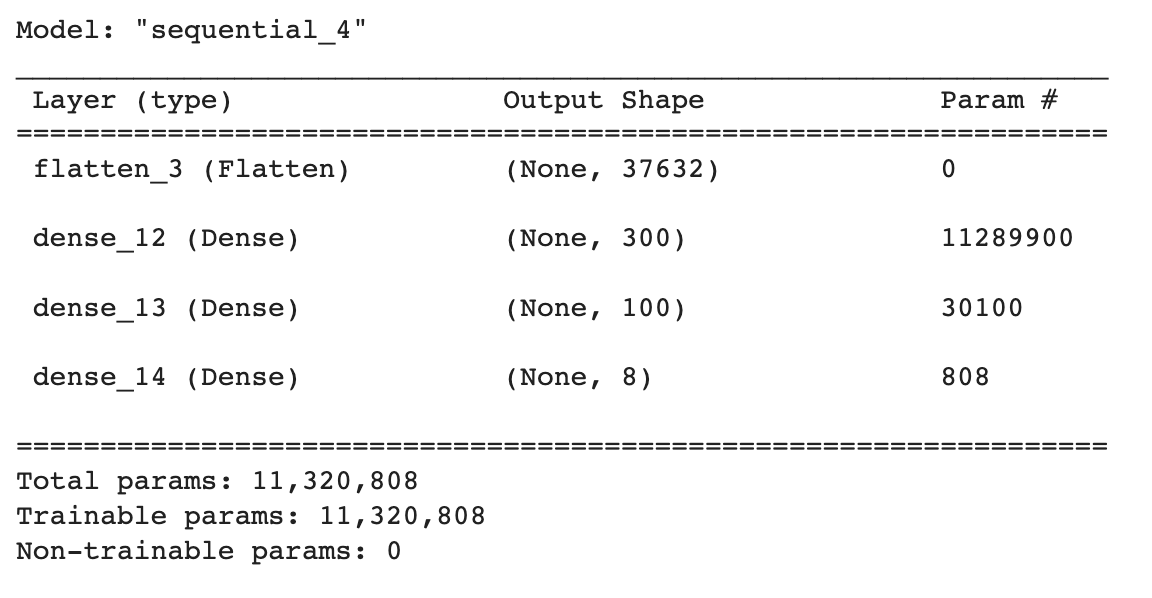

### **Simple CNN Model Summary**

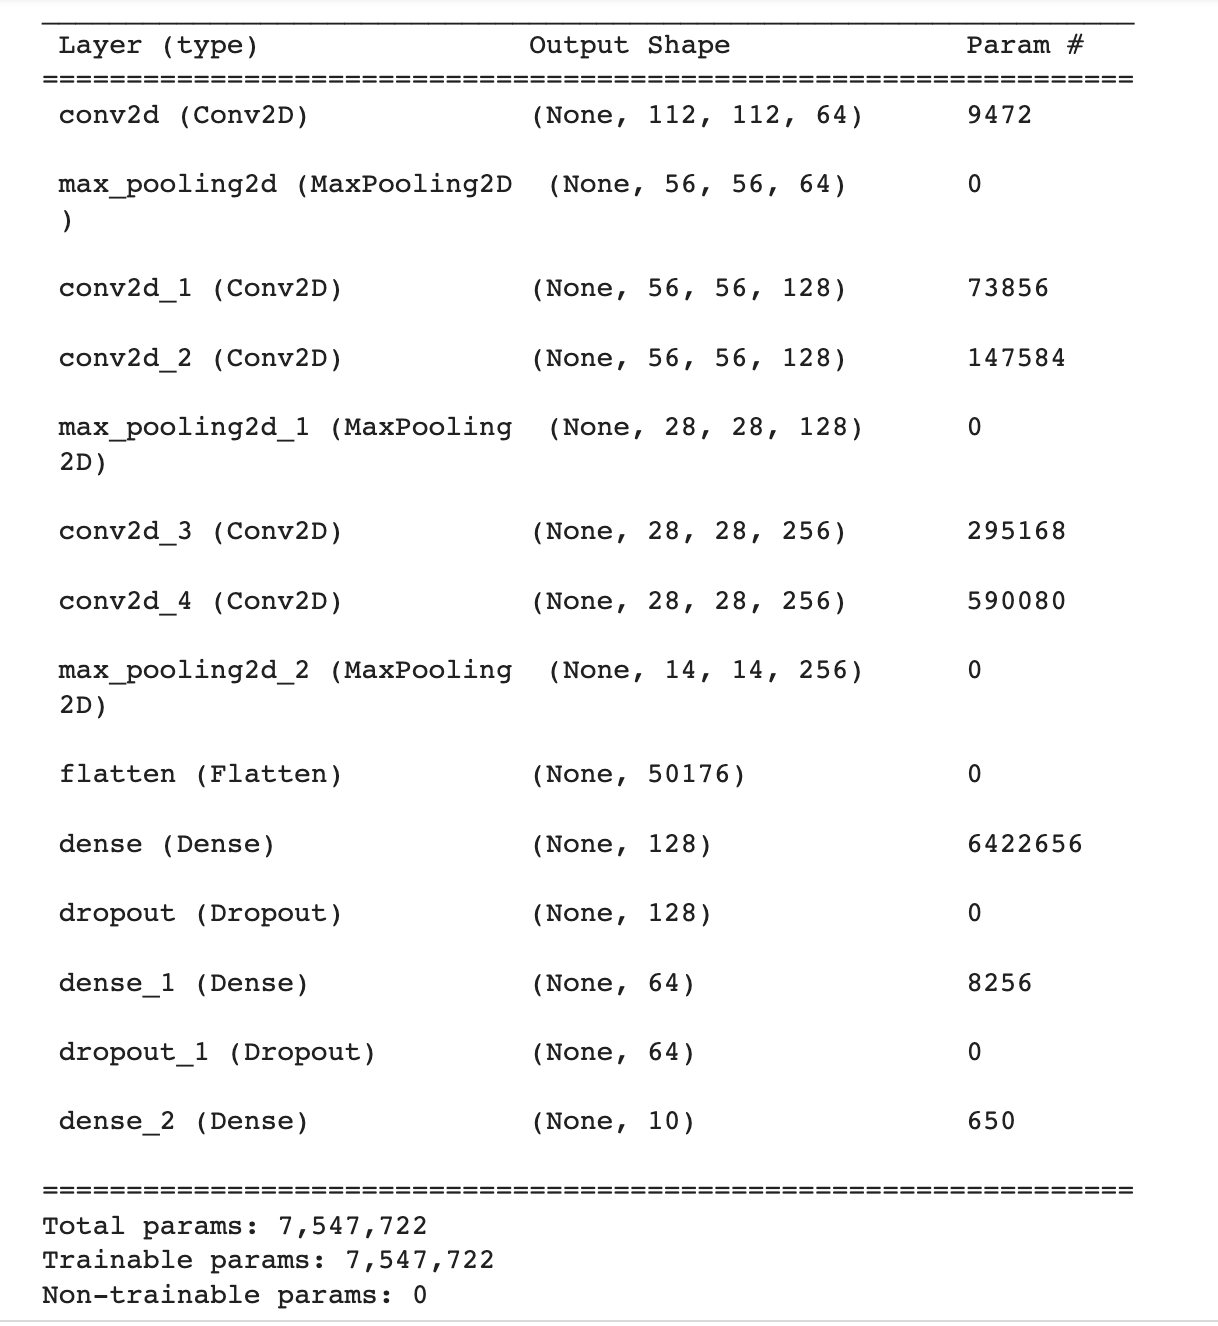

# Notes on the Deep Learning Model

- After fine-tuning, the performance of both the MLP and simple CNN models did not improve significantly, with accuracies remaining below 60%.
- The study found that increasing the size of the input image improved the performance of the model (TensorFlow Hub, n.d.). For this task, the input image size was increased from 112 x 112 in the conventional model to 512 x 512 with 3 color channels, which is the required input for the EfficientV2 (XL) model.
- The layers of the base model were frozen and used for feature extraction. An output classifier was added and trained to predict labels specifically for this task.
- The performance of the pre-trained model was satisfactory, achieving an accuracy of 93%.
- However, training this model was time and resource-intensive. It could only be run successfully on a MacBook Pro with an M2 processing unit.
- Due to time and resource constraints, the EfficientV2 (s) model was used for the fine-grained dataset. The input image size was reduced to 384 x 384.
The performance of the fine-grained model was satisfactory, achieving an accuracy of 75%.

# Discussion of Model Performance and Implementation

When comparing the final results of my conventional machine learning and deep learning models, the deep learning model outperformed the conventional one by 40% on the public test set. It ranked first out of 12 submissions, achieving an impressive accuracy of 93%.

The model achieved similar accuracy on both the validation and public test sets, as well as on the private and public test sets. This suggests that the model is not overfitting to the training data and is able to generalize well to new data.



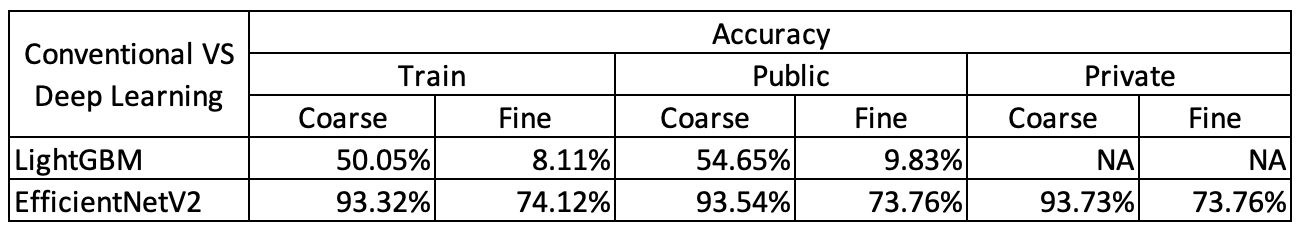

# Reference

Geron. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media, Incorporated.

Team, Keras. (n.d.). Keras Documentation: Keras applications. Keras. Retrieved June 1, 2023, from http://keras.io/api/applications/ 

TensorFlow Hub. (n.d.). Tfhub.dev. Retrieved June 1, 2023, from https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2

ImageNet. (n.d.). Www.image-Net.org. Retrieved June 1, 2023, from https://www.image-net.org/challenges/LSVRC/2011/index.php

‌

‌